<a href="https://colab.research.google.com/github/akhilkusuma0502/DesignProjects/blob/master/RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System



In [1]:
!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-25m.zip \
    -O /tmp/ml-25m.zip

--2020-07-07 01:33:38--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘/tmp/ml-25m.zip’

/tmp/ml-25m.zip     100%[===================>] 249.84M  17.3MB/s    in 16s     

2020-07-07 01:33:55 (15.8 MB/s) - ‘/tmp/ml-25m.zip’ saved [261978986/261978986]



In [2]:
pip install fuzzywuzzy

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import gc

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
import zipfile
local_zip = '/tmp/ml-25m.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [5]:
movies_filename = "/tmp/ml-25m/movies.csv"
ratings_filename = "/tmp/ml-25m/ratings.csv"

In [6]:
df_movies = pd.read_csv(
            movies_filename,
            usecols=['movieId', 'title'],
            dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(
            ratings_filename,
            usecols=['userId', 'movieId', 'rating'],
            dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [7]:
print("Shape of the Movies Dataframe: {}".format(df_movies.shape))
print("Shape of the Ratings Dataframe: {}".format(df_ratings.shape))

Shape of the Movies Dataframe: (62423, 2)
Shape of the Ratings Dataframe: (25000095, 3)


In [8]:
df_ratings=df_ratings[:2000000]
print("Shape of the Ratings Dataframe: {}".format(df_ratings.shape))

Shape of the Ratings Dataframe: (2000000, 3)


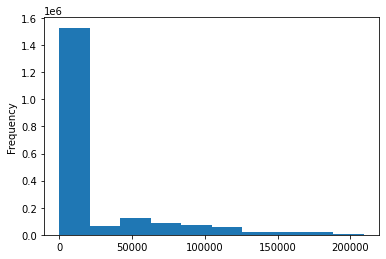

In [9]:
df_ratings['movieId'].plot(kind='hist')

In [10]:
movies_count_df = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(movies_count_df.query('count >= 50').index))  # noqa
movies_filter = df_ratings.movieId.isin(popular_movies).values
movies_filter

array([ True,  True,  True, ...,  True,  True,  True])

In [11]:
users_count_df = pd.DataFrame(df_ratings.groupby('userId').size(),columns=['count'])
active_users = list(set(users_count_df.query('count >= 50').index))  # noqa
users_filter = df_ratings.userId.isin(active_users).values
users_filter

array([ True,  True,  True, ..., False, False, False])

In [12]:
filtered_ratings_df = df_ratings[movies_filter & users_filter]
filtered_ratings_df.shape

(1691783, 3)

In [13]:
movie_user_mat = filtered_ratings_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,1,2,3,4,5,8,9,10,12,13,15,18,19,20,21,23,25,27,31,35,36,37,38,40,41,43,44,46,47,50,55,57,58,59,60,61,62,64,66,67,...,13255,13256,13257,13258,13259,13260,13261,13264,13266,13267,13270,13272,13280,13281,13282,13283,13285,13288,13289,13290,13291,13292,13295,13298,13299,13300,13301,13303,13304,13305,13306,13307,13308,13309,13310,13312,13313,13314,13315,13321
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,4.0,0.0,3.5,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,3.0,...,1.0,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,4.5,0.0,4.0,0.0,5.0,4.0,0.0,0.0,5.0,0.0,4.5,2.0,0.0,3.5,0.0,3.0,3.0,3.5,3.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,3.5,2.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1.5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
movie_titles_dict = { movie: i for i, movie in 
                     enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))   }

In [15]:
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
movie_user_mat_sparse


<4870x8313 sparse matrix of type '<class 'numpy.float32'>'
	with 1691783 stored elements in Compressed Sparse Row format>

In [16]:
del df_movies, movies_count_df, users_count_df
del df_ratings, filtered_ratings_df, movie_user_mat
gc.collect() 

32

The below function
----------
        return the closest match via fuzzy ratio.
        If no match found, return None
        Parameters
        
        movie_titles_dict: dict, map movie title name to index of the movie in data
        movie_name: str, name of user input movie
        Return
        
        index of the closest match
------

In [17]:
def get_fuzz_matching(movie_titles_dict, movie_name):
        match = []
        # get match
        for title, index in movie_titles_dict.items():
            ratio = fuzz.ratio(title.lower(), movie_name.lower())
            if ratio >= 60:
                match.append((title, index, ratio))
        # sort
        match = sorted(match, key=lambda x: x[2])[::-1]
        if not match:
            print('Sorry We found no similar movies related to {}'.format(movie_name))
        else:
            print('Found Similar movies : '
                  '{0}\n'.format([x[0] for x in match]))
            return match[0][1]

The below function get_recommendations takes below number of arguments
----------
        make top n movie recommendations
        Parameters
        
        fav_movie: str, name of user input movie
        n_recommendations: int, top n recommendations
        movie_user_mat_sparse: movie-user scipy sparse matrix
        movie_titles_dict: dict, map movie title name to index of the movie in data
----------
----------
        set model params for sklearn.neighbors.NearestNeighbors
        Parameters
        n_neighbors: int, optional (default = 5)
        algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        metric: string or callable, default 'minkowski', or one of
            ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
        n_jobs: int or None, optional (default=None)
-----------

In [18]:
 def get_recommendations(movie_name, Number_of_recommendations,movie_user_mat_sparse,movie_titles_dict):
        #Model
        model=NearestNeighbors(n_neighbors=Number_of_recommendations,algorithm='brute',metric='cosine')
        
        #Fit the model with sparse matrix data
        model.fit(movie_user_mat_sparse)

        print('You have input movie:', movie_name)
        print('Number of Recommendations requested :', Number_of_recommendations)

        #Get Nearest Fuzz Ratio
        index = get_fuzz_matching(movie_titles_dict, movie_name)
        
        #Get Indices and Distances of Nearest neighbors
        distances, indices = model.kneighbors(
            movie_user_mat_sparse[index],
            n_neighbors=Number_of_recommendations+1)
        # # get recommendations
        recommendations = sorted(list(zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )),key=lambda x: x[1])[:0:-1]
        # print results
        return recommendations

In [19]:
movie_name=str(input("Enter a movie name: "))
Number_of_recommendations=int(input("Enter Number of Similar Movies: "))
recommendations=get_recommendations(movie_name, Number_of_recommendations,movie_user_mat_sparse,movie_titles_dict)
reverse_movie_titles_dict = {v: k for k, v in movie_titles_dict.items()}
print('Recommendations for {}:'.format(movie_name))
for i, (index, distance) in enumerate(recommendations):
  print('{0}: {1}, with distance of {2}'.format(i+1, reverse_movie_titles_dict[index], distance))

Enter a movie name: Iron Man
Enter Number of Similar Movies: 15
You have input movie: Iron Man
Number of Recommendations requested : 15
Found Similar movies : ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendations for Iron Man:
1: Bourne Ultimatum, The (2007), with distance of 0.44641149044036865
2: Lord of the Rings: The Return of the King, The (2003), with distance of 0.44472944736480713
3: Sherlock Holmes (2009), with distance of 0.43893349170684814
4: Casino Royale (2006), with distance of 0.4377186894416809
5: Up (2009), with distance of 0.4376955032348633
6: Guardians of the Galaxy (2014), with distance of 0.4140666127204895
7: Dark Knight Rises, The (2012), with distance of 0.41396188735961914
8: Inception (2010), with distance of 0.4026440978050232
9: Star Trek (2009), with distance of 0.3991345763206482
10: WALL·E (2008), with distance of 0.3928523659706116
11: Avatar (2009), with distance of 0.3830743432044983
12: Batman Begins (2005), with distance of

------------
# **Solving Data Sparcity Problem using Matrix Factorization:- Effective Dimension Reduction Technique**.
------------




In [20]:
pip install pyspark

     |████████████████████████████████| 204.7MB 66kB/s 
     |████████████████████████████████| 204kB 27.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=dd7c20cff841e4ff9562f3b4f456e4e39b41efd5c78eda58560a914b0ec6911f
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

In [22]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [23]:
data_path='/tmp/ml-25m/'
movies = spark.read.load(data_path+'movies.csv', format='csv', header=True, inferSchema=True)
ratings = spark.read.load(data_path+'ratings.csv', format='csv', header=True, inferSchema=True)
links = spark.read.load(data_path+'links.csv', format='csv', header=True, inferSchema=True)
tags = spark.read.load(data_path+'tags.csv', format='csv', header=True, inferSchema=True)

In [24]:
print(movies.show(5))
print(ratings.show(5))
print(links.show(5))
print(tags.show(5))

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

None
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows

None
+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|1148

# Distinct Ratings

In [25]:
print("Distinct Ratings : \n")
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct Ratings : 

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [26]:
#Minimum number of ratings per user and minimum number of ratings per movie
print("Mininum Number of ratings per user: {}".format(ratings.groupby("userId").count().toPandas()['count'].min()))
print("Mininum Number of ratings per movie: {}".format(ratings.groupby("movieId").count().toPandas()['count'].min()))

Mininum Number of ratings per user: 20
Mininum Number of ratings per movie: 1


In [27]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 59047 distinct movies that are rated by users in ratings table
We have 3376 movies that are not rated yet


In [28]:
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print("List of movies which are not rated yet: ")
not_rated_query="""
              SELECT m.movieId,m.title
              FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId
              WHERE r.movieId IS NULL
              """
spark.sql(not_rated_query).show(10)

List of movies which are not rated yet: 
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
| 104656|Across the Sierra...|
| 105796|Back in the Saddl...|
| 121749|    War Drums (1957)|
| 124743|I Take This Woman...|
| 128131|The Castro's Abbe...|
| 132406|Hotel Colonial (1...|
| 147958|While New York Sl...|
| 150822| Mask of Dust (1954)|
| 156156|Swordswomen Three...|
| 156296|Time Out for Rhyt...|
+-------+--------------------+
only showing top 10 rows



In [29]:
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
print('All distinct genres with number of movies: ')
movies.select('movieId',explode(splitter("genres")).alias("genres")).groupby('genres').count().sort(desc('count')).show()

All distinct genres with number of movies: 
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adventure| 4145|
|            Sci-Fi| 3595|
|          Children| 2935|
|         Animation| 2929|
|           Mystery| 2925|
|           Fantasy| 2731|
|               War| 1874|
|           Western| 1399|
|           Musical| 1054|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+



In [30]:
movie_rating = sc.textFile(data_path+'ratings.csv')
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda column: (int(column[0]), int(column[1]), float(column[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 296, 5.0), (1, 306, 3.5), (1, 307, 5.0)]